In [1]:
from myai.imports import *
from visualbench.tasks.function_descent import FunctionDescent
from visualbench.tasks.box_packing import BoxPacking
from visualbench.tasks.inverse import MatrixInverse
from visualbench.tasks.mnist1d_ import MNIST1D
from torchzero.optim.wrappers.scipy import ScipyMinimize
from visualbench.summary import Summary
from myai.datasets.visualbench_plug import MyaiDataset
from myai.datasets import CIFAR10, MNIST
import torchzero as tz

import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, ndim = 2):
        super(BasicBlock, self).__init__()
        self.conv1 = mynn.convnd(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False, ndim=ndim)
        self.bn1 = nn.BatchNorm2d(out_channels) if ndim == 2 else nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = mynn.convnd(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False, ndim = ndim)
        self.bn2 = nn.BatchNorm2d(out_channels) if ndim == 2 else nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                mynn.convnd(in_channels, out_channels, kernel_size=1, stride=stride, bias=False, ndim = ndim),
                nn.BatchNorm2d(out_channels) if ndim == 2 else nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, in_channels, step = 32, num_classes=10, ndim = 2):
        super(ResNet18, self).__init__()
        self.in_channels = step
        self.conv1 = mynn.convnd(in_channels, step, kernel_size=3, stride=1, padding=1, bias=False, ndim = ndim)
        self.bn1 = nn.BatchNorm2d(step) if ndim == 2 else nn.BatchNorm1d(step)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = mynn.maxpoolnd(kernel_size=3, stride=2, padding=1, ndim = ndim)

        self.layer1 = self._make_layer(BasicBlock, step, 2, stride=1, ndim=ndim)
        self.layer2 = self._make_layer(BasicBlock, step*2, 2, stride=2, ndim=ndim)
        self.layer3 = self._make_layer(BasicBlock, step*4, 2, stride=2, ndim=ndim)
        self.layer4 = self._make_layer(BasicBlock, step*8, 2, stride=2, ndim=ndim)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) if ndim == 2 else nn.AdaptiveAvgPool1d((1,))
        self.fc = nn.Linear(step*8, num_classes)

        self.ndim = ndim

    def _make_layer(self, block, out_channels, num_blocks, stride, ndim):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, ndim))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.ndim == 1 and x.ndim == 2: x = x.unsqueeze(1)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

print(f'{count_params(ResNet18(3, 32, 10)) = }')
print(f'{count_params(ResNet18(1, 8, 10)) = }')


count_params(ResNet18(3, 32, 10)) = 2797610
count_params(ResNet18(1, 8, 10)) = 176258


In [48]:
import math
import torch
from torch.optim.optimizer import Optimizer

class CubicOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, beta3=0.999, epsilon=1e-8):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, beta3=beta3, epsilon=epsilon)
        super().__init__(params, defaults)

    @torch.no_grad
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad(): loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('CubicOptimizer does not support sparse gradients')

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['m'] = torch.zeros_like(p)
                    state['v'] = torch.zeros_like(p)
                    state['t'] = torch.zeros_like(p)

                m, v, t = state['m'], state['v'], state['t']
                beta1, beta2, beta3 = group['beta1'], group['beta2'], group['beta3']
                state['step'] += 1

                # Update moments
                m.mul_(beta1).add_(grad, alpha=1 - beta1)
                v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                t.mul_(beta3).addcmul_(grad, grad.mul(grad), value=1 - beta3)

                # Bias correction
                m_hat = m / (1 - beta1**state['step'])
                v_hat = v / (1 - beta2**state['step'])
                t_hat = t / (1 - beta3**state['step'])

                # Solve cubic equation: t_hat*δ^3 + v_hat*δ + m_hat = 0
                delta = torch.zeros_like(p)
                flat_t = t_hat.flatten()
                flat_v = v_hat.flatten()
                flat_m = m_hat.flatten()
                flat_delta = delta.flatten()

                for i in range(len(flat_t)):
                    ti = flat_t[i].item() + group['epsilon']
                    vi = flat_v[i].item()
                    mi = flat_m[i].item()

                    # Normalize to depressed cubic: x^3 + px + q = 0
                    p_ = vi / ti
                    q = mi / ti

                    # Cardano's method
                    discriminant = (q/2)**2 + (p_/3)**3
                    if discriminant > 0:
                        u = (-q/2 + math.sqrt(discriminant)) ** (1/3)
                        v = (-q/2 - math.sqrt(discriminant)) ** (1/3)
                        root = u + v
                    elif discriminant == 0:
                        root = 3*q/p_ if p_ != 0 else 0.0
                    else:
                        theta = math.acos(3*q/(2*p_) * math.sqrt(-3/p_))
                        root = 2 * math.sqrt(-p_/3) * math.cos(theta/3)

                    flat_delta[i] = -group['lr'] * root

                p.sub_(delta)

        return loss

    def _solve_cubic(self, a, b, c):
        """Helper function to solve cubic equations"""
        pass  # Implemented inline in step for performance

<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<function scale_by_soap at 0x7fbe4a5d8680>


No ROCm runtime is found, using ROCM_HOME='/opt/rocm'


<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<function scale_by_soap at 0x7fbe4a5d8680>
<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<function scale_by_soap at 0x7fbe4a5d8680>
<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<function scale_by_soap at 0x7fbe4a5d8680>
<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<function scale_by_soap at 0x7fbe4a5d8680>
<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<function scale_by_soap at 0x7fbe4a5d8680>
<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<function scale_by_soap at 0x7fbe4a5d8680>
<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<function scale_by_soap at 0x7fbe4a5d8680>
<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<function scale_by_soap at 0x7fbe4a5d8680>
<heavyball.chainable.ZeroGuard object at 0x7fbe6589a240> False
<function scale_by_soap at 0x7fbe4a5d8680>
<heavyball.chainable.ZeroGuard object at 0x7fb

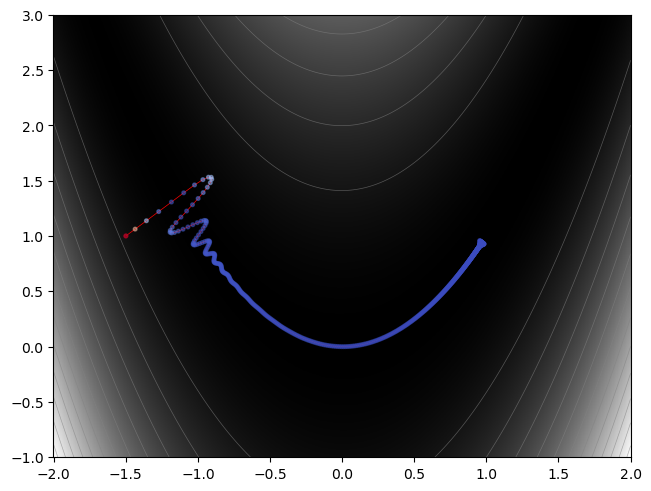

In [51]:
from heavyball import SOAP
bench = FunctionDescent('rosen')
opt = SOAP(bench.parameters(),  1e-1,)
bench.run(opt, 1000,)
bench.plot_solution()

In [ ]:
bench.render_video('eveoe')

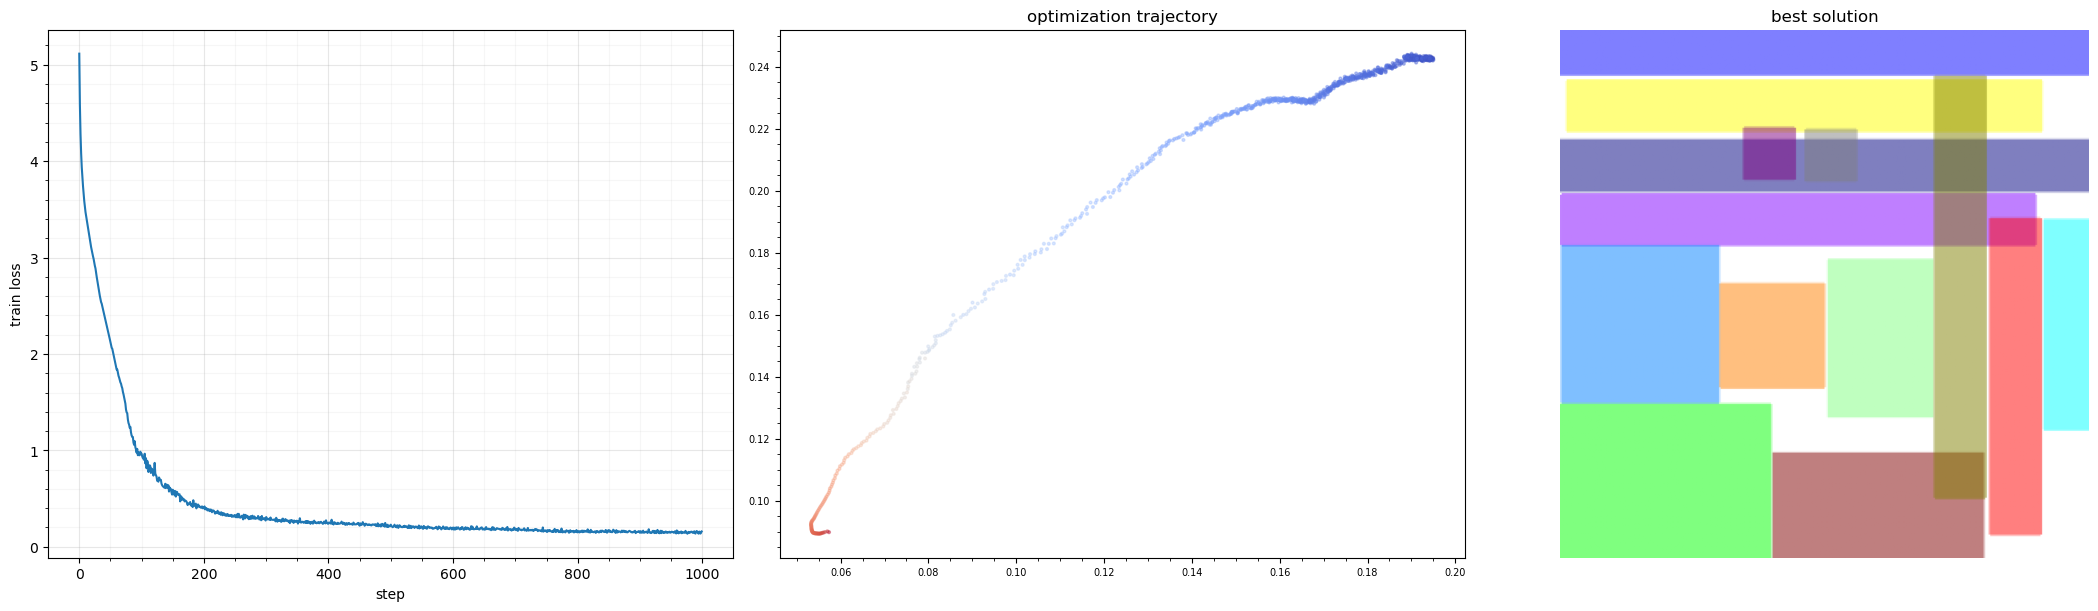

In [22]:
bench = BoxPacking()
opt = FourierPreconditioner(bench.parameters(), 1e-2)
bench.run(opt, 1000)
bench.plot_summary(1, fig=Fig().figsize(24, 6))

In [23]:
bench.render_video('FourierPreconditioner')

1000/1000 | 11.21s               


image.shape = torch.Size([3, 229, 229]), image.numel() = 157323


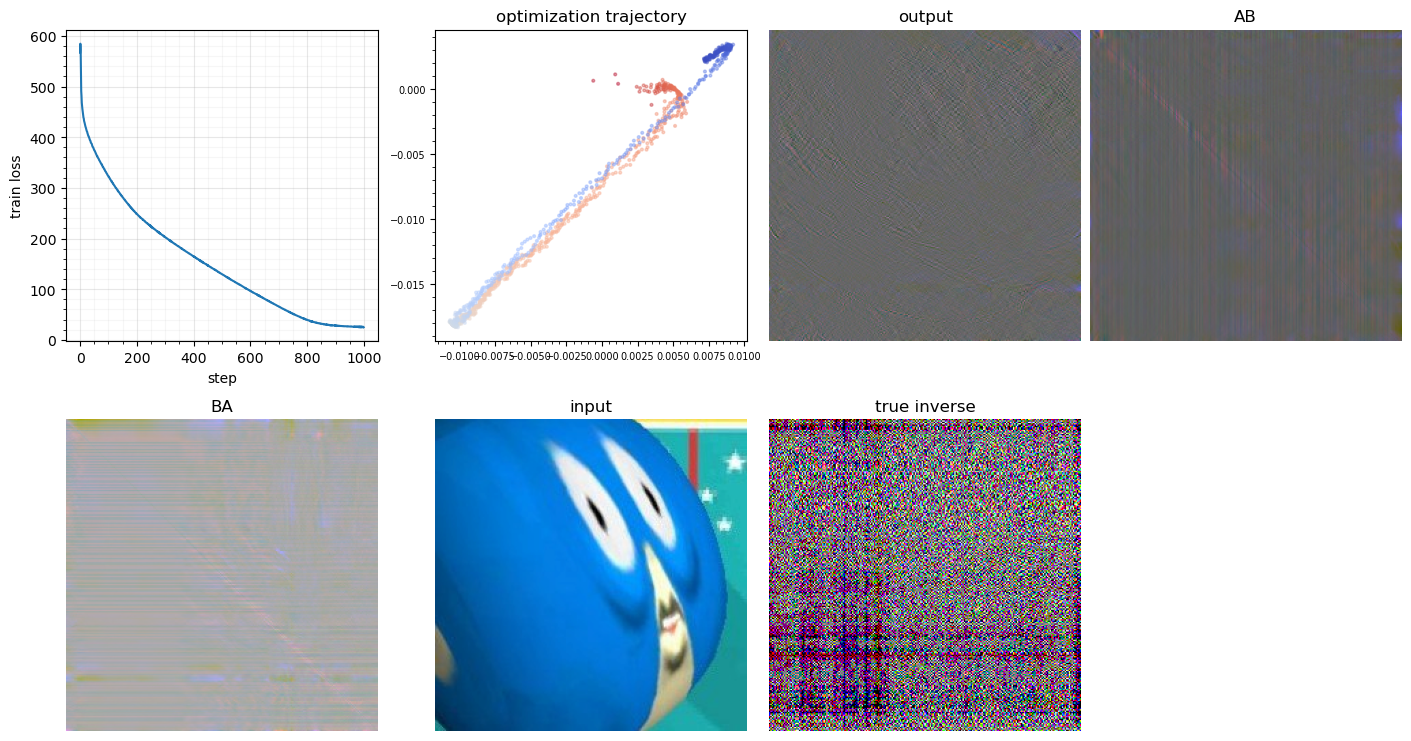

In [30]:
REDUCTION = 0
BW = False

image = znormalize(imreadtensor('/var/mnt/ssd/Файлы/Изображения/Сохраненное/sanic.jpg').float())
if REDUCTION > 1:
    image = image[:,::REDUCTION,::REDUCTION].clone()
if BW: image = image.mean(0)

print(f'{image.shape = }, {image.numel() = }')
bench = MatrixInverse(image)
opt = FourierPreconditioner(bench.parameters(), 3e-1)
bench.run(opt, 1000)
bench.plot_summary()

In [ ]:
bench.render_video('glesgd inv', scale=4)

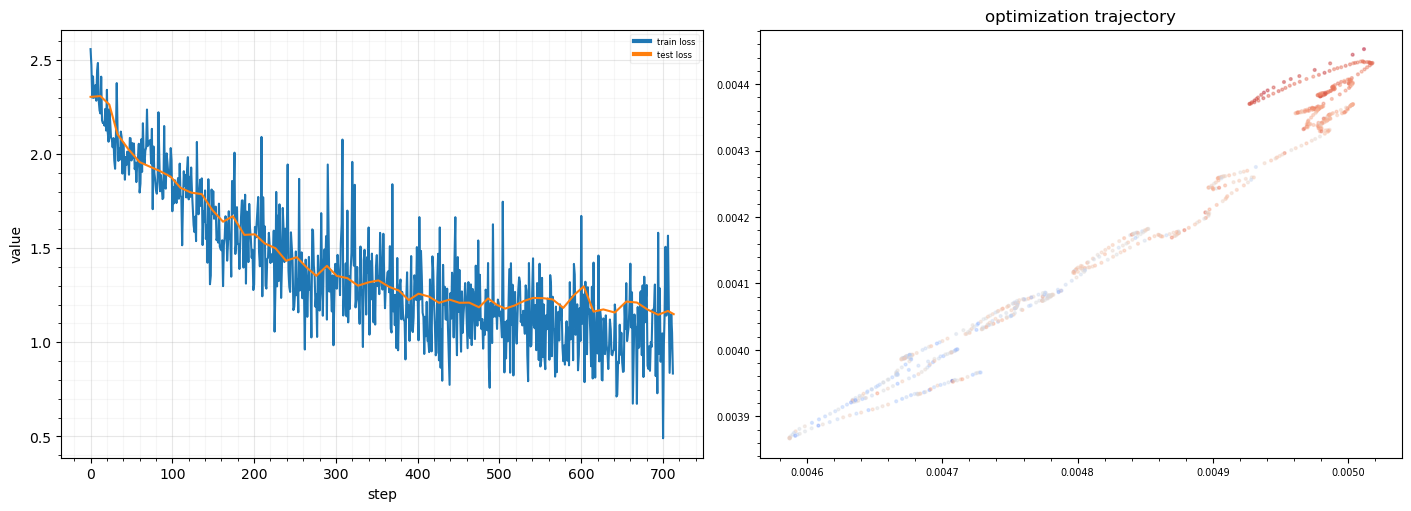

In [34]:
clean_mem()
bench = MNIST1D(
    ResNet18(1, 8, 10, 1),
    loss = F.cross_entropy,
    batch_size = 32,
    test_batch_size = None,
).cuda()

opt = sig(LambertWOptimizer, bench.parameters(), 1e-3)

bench.run(
    opt,
    max_time = 60,
    test_every_sec = 1,
    name = None
)

bench.save_run('MNIST1d-32 runs')
bench.plot_summary()

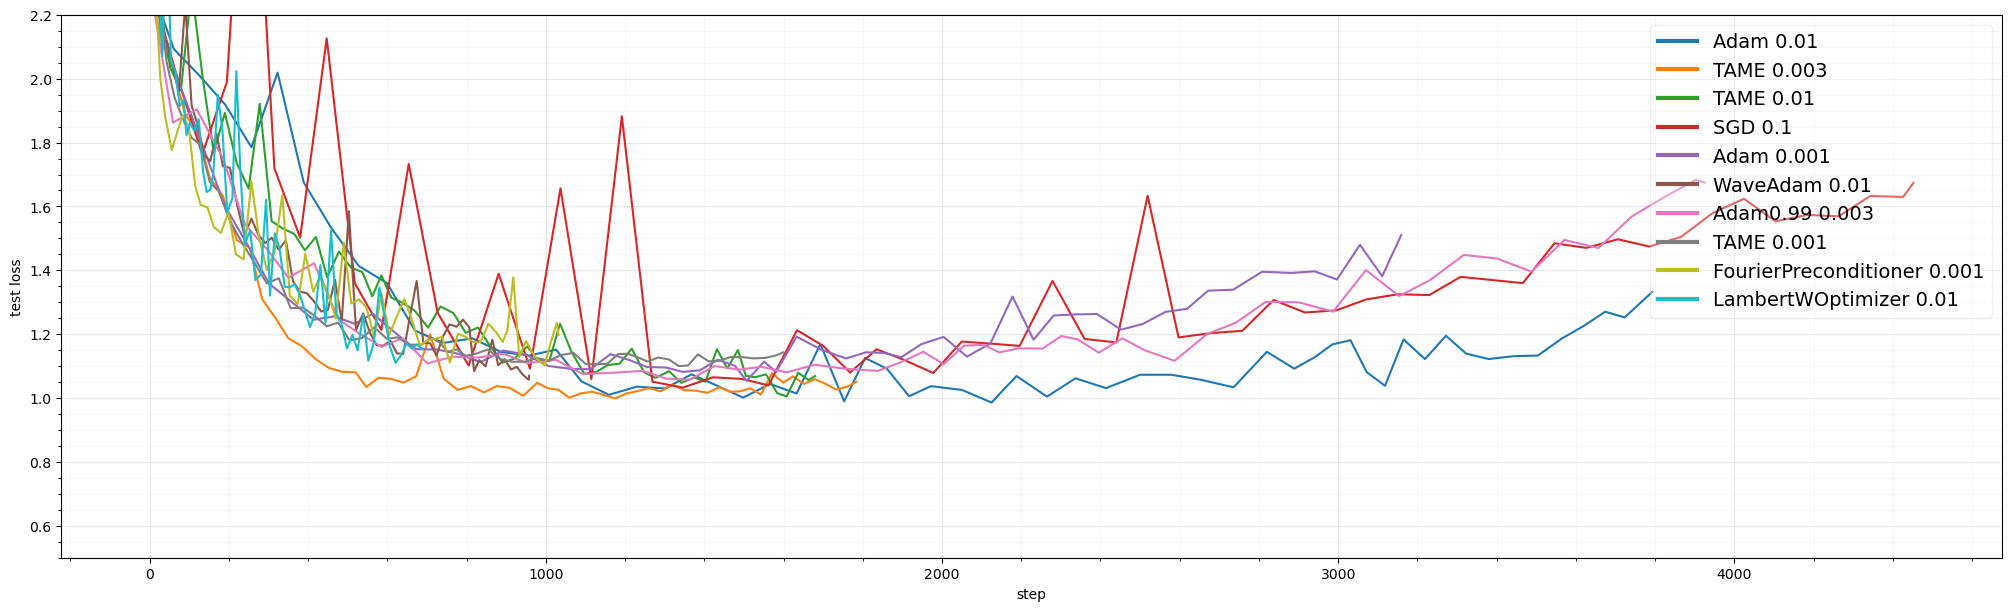

In [35]:
s = Summary.from_runs_dir('MNIST1d-32 runs')
(
s
.map_name('name', 'optimizer/lr')
.sorted_by_metric('test loss', 'min')
.comparison
.plot('test loss', highest=False)
.ylim(0.5, 2.2)
.legend(size=14, loc='upper right')
.figsize(20, 6)
.show()
)

In [36]:
s = Summary.from_runs_dir('MNIST1d-32 runs')

import polars as pl
pl.Config.set_tbl_rows(100)
s.map_name('name', 'optimizer/lr').sorted_by_metric('test loss', 'min').to_polars('name', 'logger/test loss/min', 'attrs/current_step')

name,logger/test loss/min,attrs/current_step
str,f32,i64
"""Adam 0.01""",0.985916,3793
"""TAME 0.003""",0.998399,1784
"""TAME 0.01""",1.00513,1680
"""SGD 0.1""",1.032747,4452
"""Adam 0.001""",1.053944,3159
"""WaveAdam 0.01""",1.057189,958
"""Adam0.99 0.003""",1.057429,3925
"""TAME 0.001""",1.099992,1599
"""FourierPreconditioner 0.001""",1.102083,1032


In [58]:
from myai.research.optimizers.tame import TAME

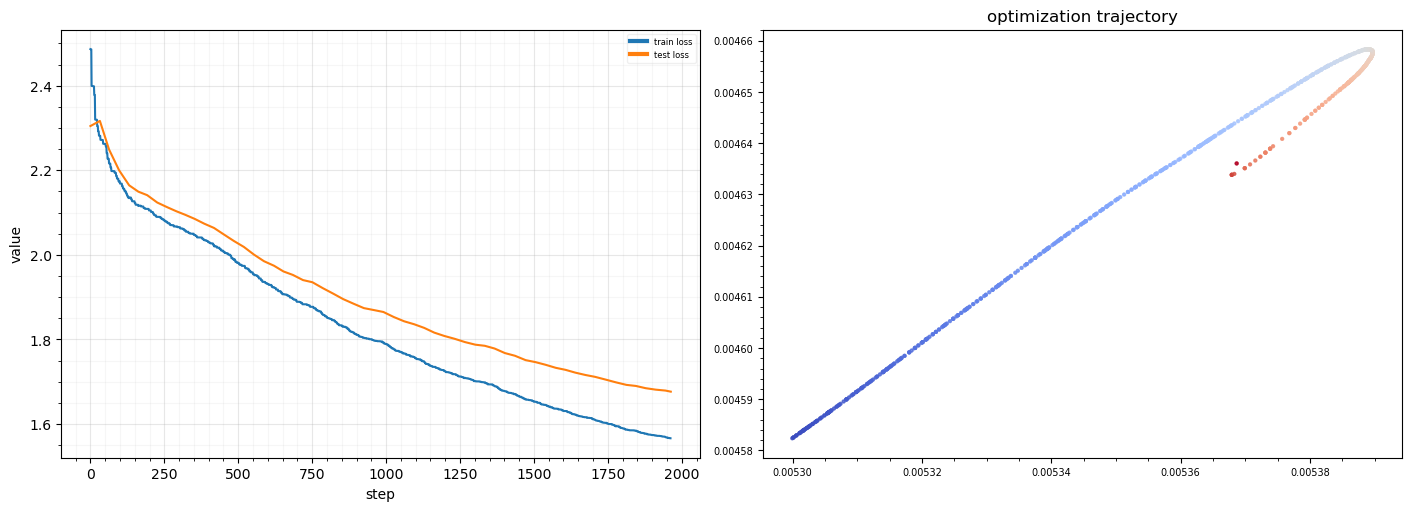

In [60]:
clean_mem()
bench = MNIST1D(
    ResNet18(1, 8, 10, 1),
    loss = F.cross_entropy,
    batch_size = None,
    test_batch_size = None,
)

opt = sig(TAME, bench.parameters())

bench.run(
    opt,
    max_time = 60,
    test_every_sec = 1,
    name = None,
)

bench.save_run('MNIST1d-fullbatch runs')
bench.plot_summary()

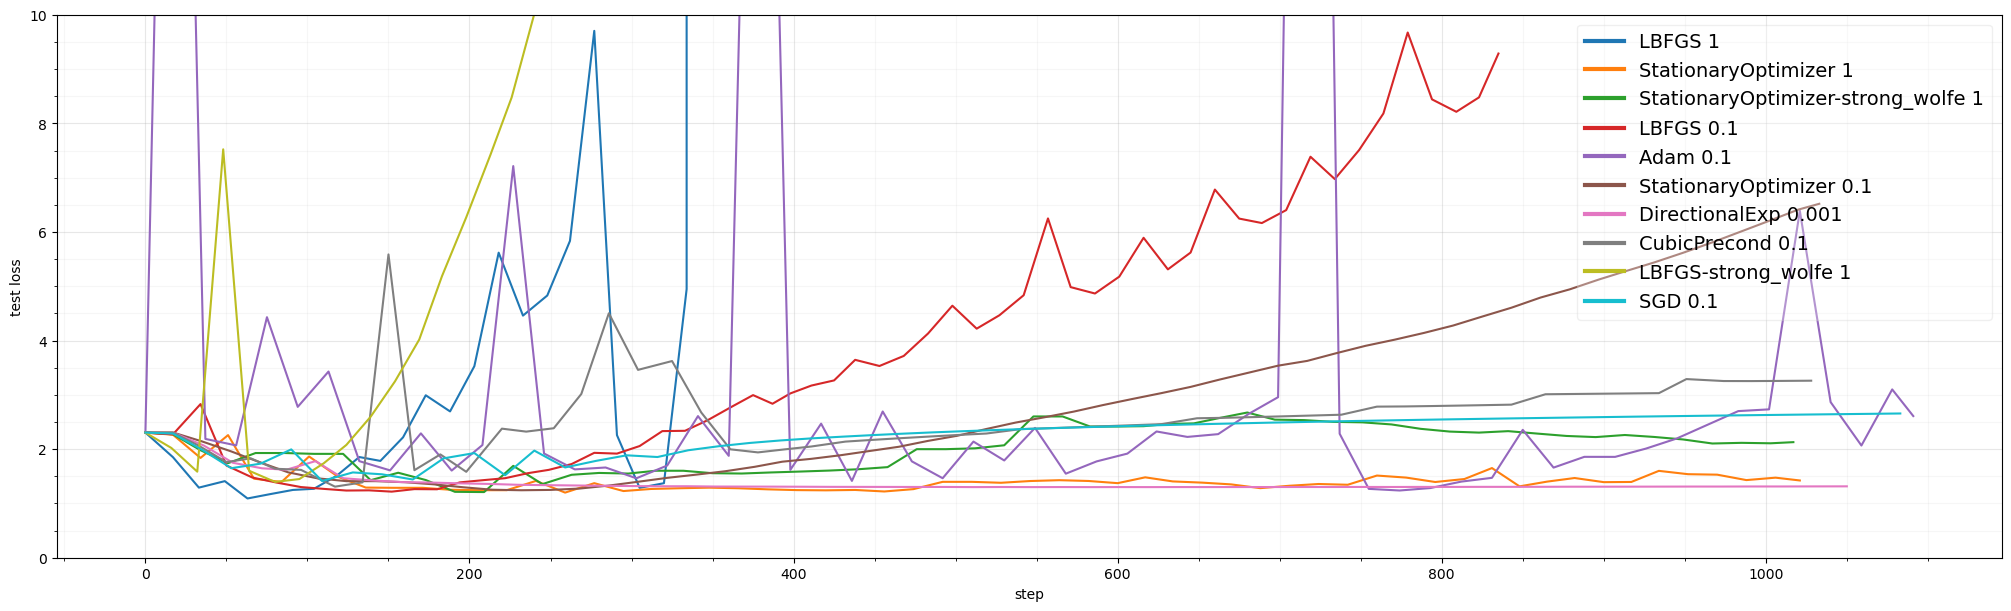

In [61]:
s = Summary.from_runs_dir('MNIST1d-fullbatch runs')
(
s
.map_name('name', 'optimizer/lr')
.sorted_by_metric('test loss', 'min')
.comparison
.plot('test loss', highest=False)
.ylim(0.0, 10)
.legend(size=14, loc='upper right')
.figsize(20, 6)
.show()
)

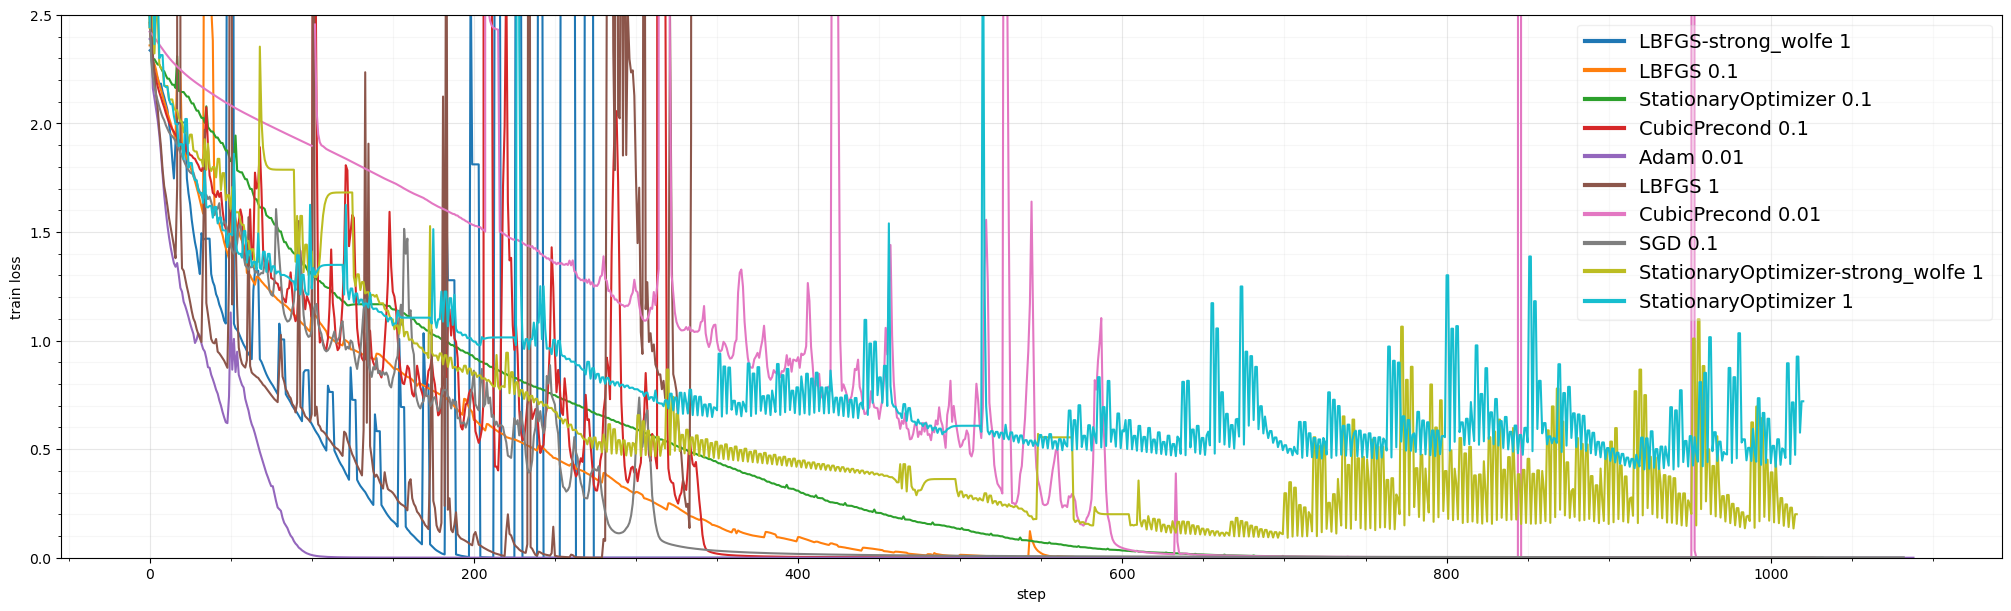

In [65]:
s = Summary.from_runs_dir('MNIST1d-fullbatch runs')
(
s
.map_name('name', 'optimizer/lr')
.sorted_by_metric('test loss', 'min')
.comparison
.plot('train loss', highest=False,)
.ylim(0.0, 2.5)
.legend(size=14, loc='upper right')
.figsize(20, 6)
.show()
)

In [8]:
s = Summary.from_runs_dir('MNIST1d-fullbatch runs')

import polars as pl
pl.Config.set_tbl_rows(100)
s.map_name('name', 'optimizer/lr').sorted_by_metric('test loss', 'min').to_polars('name', 'logger/test loss/min', 'attrs/current_step')

name,logger/test loss/min,attrs/current_step
str,f32,i64
"""LBFGS 1""",1.091433,833
"""StationaryOptimizer 1""",1.199481,1021
"""StationaryOptimizer-strong_wol…",1.209188,1017
"""LBFGS 0.1""",1.21727,835
"""Adam 0.1""",1.238158,1091
"""StationaryOptimizer 0.1""",1.242848,1033
"""LBFGS-strong_wolfe 1""",1.396248,979
"""SGD 0.1""",1.413328,1083
"""Adam 0.01""",1.53852,1089
